In [1]:
# 파일 전체가 제대로 실행되는지 확인하기 위한 테이블 지우는 코드
import mysql.connector
remote = mysql.connector.connect(
    host = "database-1.c3mmsaki87vo.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "admin",
    password = "rlawlswo1",
    database = "amrbase"
)
cur = remote.cursor()
cur.execute("""drop table ediya_info""")
cur.execute("""drop table starbucks_info""")
cur.execute("""drop table ediya_latlng""")
cur.execute("""drop table starbucks_latlng""")
cursor = remote.cursor(buffered=True)

In [2]:
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import urllib
from urllib.request import Request
from urllib.request import urlopen

from user_agent import generate_user_agent
import time

from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

import mysql.connector

from user_agent import generate_user_agent
import time

import copy

In [3]:
options = webdriver.ChromeOptions()

prefs = {'download.default_directory':'/home/addinedu/dev_ws/EDA/data',
        'download.prompt_for_download':False}
options.add_experimental_option('prefs', prefs)

url = "https://www.starbucks.co.kr/store/store_map.do"
driver = webdriver.Chrome(service=Service("./driver/chromedriver"),
                          options=options)

driver.get(url)

접속한 사이트(스타벅스 매장지도)에서 데이터를 얻기 위해 사이트 제어

In [4]:
from selenium.webdriver.common.by import By
click_link = driver.find_element(By.CLASS_NAME, "loca_search")
click_link.click()
driver.implicitly_wait(3)

In [5]:
sido_list = driver.find_element(By.CLASS_NAME, "sido_arae_box")
sido_click = sido_list.find_elements(By.TAG_NAME, "li")
for idx, sido in enumerate(sido_click):
    if sido.text == '서울':
        sido.click()
        driver.implicitly_wait(3)

스타벅스의 매장지점이름, 주소를 얻는 코드

In [6]:
real_shop_list = []
gu_list = driver.find_element(By.CLASS_NAME, "gugun_arae_box")
gu_click = gu_list.find_elements(By.TAG_NAME, "li")
driver.implicitly_wait(3)
for idx, gu in enumerate(gu_click):
    if gu.text == "전체":
        gu.click()
        time.sleep(4)
        driver.implicitly_wait(3)

        page = driver.page_source
        soup = BeautifulSoup(page, "html")

        seoul_list = soup.find(class_="store_map_layer_cont")
        temp = seoul_list.find(id="mCSB_3_container")
        shop_list = temp.find_all("li")
        for idx, shop in enumerate(shop_list):
            real_shop_list.append(shop.text)
        driver.implicitly_wait(3)

주소에서 지역구 이름을 추출

In [7]:
shop_info = []
list_temp = []
gu_list = []
for idx, shop in enumerate(real_shop_list):
    driver.implicitly_wait(3)
    temp = shop[:-10]
    temp = temp[:-9]
    list_temp = temp.split('   ')
    temp3 = temp.split('서울특별시')
    temp4 = temp3[1].split(' ')
    list_temp.append(temp4[1])
    gu_list.append(temp4[1])
    shop_info.append(list_temp)
    temp3 = shop_info[idx][1].split(' ')
    shop_info[idx][0] = shop_info[idx][0].strip()

gu_list = list(set(gu_list))
starbucks_shop_list = shop_info.copy()

In [8]:
print(gu_list)

['성동구', '강남구', '성북구', '중구', '중랑구', '강동구', '강서구', '종로구', '금천구', '은평구', '용산구', '동작구', '노원구', '광진구', '서초구', '송파구', '서대문구', '도봉구', '강북구', '양천구', '구로구', '관악구', '동대문구', '영등포구', '마포구']


지점명, 주소, 구를 저장 할 데이터베이스를 만들고 저장

In [9]:
import mysql.connector

In [10]:
remote = mysql.connector.connect(
    host = "database-1.c3mmsaki87vo.ap-northeast-2.rds.amazonaws.com",
    port = 3306,
    user = "admin",
    password = "rlawlswo1",
    database = "amrbase"
)

In [11]:
cur = remote.cursor()
cur.execute("""create table starbucks_info (
        name varchar(16), 
        address varchar(50),
        gu varchar(10))""")

In [12]:
cursor = remote.cursor(buffered=True)

In [13]:
sql = "insert into starbucks_info values (%s, %s, %s)"

In [14]:
for i, row in enumerate(starbucks_shop_list):
    cursor.execute(sql, tuple(row))
    remote.commit()

제대로 저장됬는지 확인

In [15]:
cursor.execute("select * from starbucks_info")

result = cursor.fetchall()
for row in result:
    print(row)

('역삼아레나빌딩', '서울특별시 강남구 언주로 425 (역삼동)', '강남구')
('논현역사거리', '서울특별시 강남구 강남대로 538 (논현동)', '강남구')
('신사역성일빌딩', '서울특별시 강남구 강남대로 584 (논현동)', '강남구')
('국기원사거리', '서울특별시 강남구 테헤란로 125 (역삼동)', '강남구')
('대치재경빌딩', '서울특별시 강남구 남부순환로 2947 (대치동)', '강남구')
('봉은사역', '서울특별시 강남구 봉은사로 619 (삼성동)', '강남구')
('압구정윤성빌딩', '서울특별시 강남구 논현로 834 (신사동)', '강남구')
('코엑스별마당', '서울특별시 강남구 영동대로 513 (삼성동)', '강남구')
('삼성역섬유센터R', '서울특별시 강남구 테헤란로 518 (대치동)', '강남구')
('압구정R', '서울특별시 강남구 언주로 861 (신사동)', '강남구')
('수서역R', '서울특별시 강남구 광평로 281 (수서동)', '강남구')
('양재강남빌딩R', '서울특별시 강남구 남부순환로 2621 (도곡동)', '강남구')
('선릉동신빌딩R', '서울특별시 강남구 테헤란로 409 (삼성동)', '강남구')
('봉은사로선정릉', '서울특별시 강남구 봉은사로 446 (삼성동)', '강남구')
('강남오거리', '서울특별시 강남구 봉은사로2길 39 (역삼동)', '강남구')
('스타필드코엑스몰R', '서울특별시 강남구 영동대로 513 (삼성동) 코엑스 A106호', '강남구')
('강남구청정문', '서울특별시 강남구 학동로 419 (청담동)', '강남구')
('도곡공원', '서울특별시 강남구 도곡로 205 (역삼동)', '강남구')
('강남R', '서울특별시 강남구 강남대로 390 (역삼동)', '강남구')
('대치은마사거리', '서울특별시 강남구 도곡로 457 (대치동)', '강남구')
('청담영동대로', '서울특별시 강남구 영동대로 720 (청담동)', '강남구')
('압구정', '서울특별시 강남구 압구정로30길

In [16]:
driver.close()

이디야 매장지도 페이지 접속

In [17]:
options = webdriver.ChromeOptions()

prefs = {'download.default_directory':'/home/addinedu/dev_ws/EDA/data',
        'download.prompt_for_download':False}
options.add_experimental_option('prefs', prefs)

url = "https://members.ediya.com/store"
driver = webdriver.Chrome(service=Service("./driver/chromedriver"),
                          options=options)

driver.get(url)
driver.implicitly_wait(3)

구마다 입력해서 데이터를 얻어야하기 때문에 구 입력을 위한 사이트제어

In [18]:
add_click = driver.find_element(By.XPATH, """/html/body/div/div/div/div/div/div[2]/div[1]/div[1]/a[2]""")
add_click.click()
driver.implicitly_wait(3)
print(gu_list)

['성동구', '강남구', '성북구', '중구', '중랑구', '강동구', '강서구', '종로구', '금천구', '은평구', '용산구', '동작구', '노원구', '광진구', '서초구', '송파구', '서대문구', '도봉구', '강북구', '양천구', '구로구', '관악구', '동대문구', '영등포구', '마포구']


In [19]:
add_send = driver.find_element(By.XPATH, """//*[@id="keyword"]""")
del_send = driver.find_element(By.XPATH, """/html/body/div/div/div/div/div/div[2]/div[1]/div[2]/button[1]""")

매장검색란에 각 구를 입력해 지점명, 주소, 구를 얻어옴

In [20]:
ediya_shop_list = []
shop_info_temp = []
for idx, gu in enumerate(gu_list):
    add_send.send_keys("서울 " +str(gu))
    add_send.send_keys(Keys.ENTER)
    shop_list = driver.find_element(By.CLASS_NAME, "store_list")
    shop_info_t = shop_list.find_elements(By.CLASS_NAME, "st_li")
    for idy, shop_detail in enumerate(shop_info_t):
        detail = shop_info_t[idy].find_element(By.CLASS_NAME, "info_txt")
        name = detail.find_element(By.CLASS_NAME, "name")
        addr = detail.find_element(By.CLASS_NAME, "addr")
        shop_info_temp.append(name.text)
        shop_info_temp.append(addr.text.replace("  ", " "))
        shop_info_temp.append(gu)
        print(idy, name.text, addr.text.replace("  ", " "))
        ediya_shop_list.append(shop_info_temp)
        shop_info_temp = []
    driver.implicitly_wait(3)
    del_send.click()

0 성수아카데미점 서울 성동구 성수동2가 277-17성수아카데미타워
1 왕십리역점 서울 성동구 행당동 287-15
2 옥수동점 서울 성동구 옥수동 매봉길 12
3 성수우리W타워점 서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)
4 마장동점 서울 성동구 마장동 478-38
5 왕십리센트라스점 서울 성동구 무학로 22 1층
6 텐즈힐점 서울 성동구 무학로 33 153동 102호(하왕십리동, 텐즈힐)
7 논골사거리점 서울 성동구 난계로 35 2층(금호동 1가)
8 응봉동점 서울 성동구 독서당로 381 1층 108, 109호(응봉동, 현대종합상가)
9 왕십리비트플렉스점 서울 성동구 왕십리광장로 17 지상2층
10 성수중앙점 서울 성동구 성수일로6길 47 1층 103호(성수동2가)
0 을지병원사거리점 서울 강남구 도산대로30길 7 1층(논현동)
1 학동제마점 서울 강남구 학동로34길 22 (논현동) 
2 삼성중앙역점 서울 강남구 삼성로 608 (삼성동, 우창빌딩) 1층 이디야커피
3 삼성대치점 서울 강남구 삼성로64길 32 (대치동, 주성빌딩) 1층
4 강남대치점 서울 강남구 역삼로 415 (대치동, 성진빌딩) 1층
5 강남율현점 서울 강남구 밤고개로21길 8 (율현동, 세곡프라자) 지상1층 104,105호
6 선릉역점 서울 강남구 테헤란로 332 (역삼동, 에이치제이타워) 이디야커피
7 한티역점 서울 강남구 도곡로69길 8 (대치동) 1층
8 청담역점 서울 강남구 삼성로 721 (청담동, 룩희 819) 1층
9 강남구청역아이티웨딩점 서울 강남구 학동로 338 (논현동, 강남파라곤) 이디야커피
10 학동역점 서울 강남구 학동로 219 (논현동, 국제빌딩) 2층
11 강남논현학동점 서울 강남구 논현로131길 28 1층
12 강남도산점 서울 강남구 도산대로37길 20 1층(신사동)
13 삼성한전점 서울 강남구 테헤란로 107길 11(삼성동 169-10)
14 역삼점 서울 강남구 논현로72길 13 1층(역삼동)
15 건설회관점 서울 강남구 언주로 711 1층(

이디야 데이터 확인

In [21]:
ediya_shop_list

[['성수아카데미점', '서울 성동구 성수동2가 277-17성수아카데미타워', '성동구'],
 ['왕십리역점', '서울 성동구 행당동 287-15', '성동구'],
 ['옥수동점', '서울 성동구 옥수동 매봉길 12', '성동구'],
 ['성수우리W타워점', '서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)', '성동구'],
 ['마장동점', '서울 성동구 마장동 478-38', '성동구'],
 ['왕십리센트라스점', '서울 성동구 무학로 22 1층', '성동구'],
 ['텐즈힐점', '서울 성동구 무학로 33 153동 102호(하왕십리동, 텐즈힐)', '성동구'],
 ['논골사거리점', '서울 성동구 난계로 35 2층(금호동 1가)', '성동구'],
 ['응봉동점', '서울 성동구 독서당로 381 1층 108, 109호(응봉동, 현대종합상가)', '성동구'],
 ['왕십리비트플렉스점', '서울 성동구 왕십리광장로 17 지상2층', '성동구'],
 ['성수중앙점', '서울 성동구 성수일로6길 47 1층 103호(성수동2가)', '성동구'],
 ['을지병원사거리점', '서울 강남구 도산대로30길 7 1층(논현동)', '강남구'],
 ['학동제마점', '서울 강남구 학동로34길 22 (논현동) ', '강남구'],
 ['삼성중앙역점', '서울 강남구 삼성로 608 (삼성동, 우창빌딩) 1층 이디야커피', '강남구'],
 ['삼성대치점', '서울 강남구 삼성로64길 32 (대치동, 주성빌딩) 1층', '강남구'],
 ['강남대치점', '서울 강남구 역삼로 415 (대치동, 성진빌딩) 1층', '강남구'],
 ['강남율현점', '서울 강남구 밤고개로21길 8 (율현동, 세곡프라자) 지상1층 104,105호', '강남구'],
 ['선릉역점', '서울 강남구 테헤란로 332 (역삼동, 에이치제이타워) 이디야커피', '강남구'],
 ['한티역점', '서울 강남구 도곡로69길 8 (대치동) 1층', '강남구'],
 ['청담역점', '서울 강남구 삼성로 721 (

In [22]:
driver.close()

In [23]:
cur = remote.cursor()
cur.execute("""create table ediya_info (
        name varchar(16), 
        address varchar(50),
        gu varchar(10))""")

In [24]:
cursor = remote.cursor(buffered=True)

In [25]:
sql = "insert into ediya_info values (%s, %s, %s)"

이디야 정보 입력

In [26]:
for i, row in enumerate(ediya_shop_list):
    cursor.execute(sql, tuple(row))
    remote.commit()

입력확인

In [27]:
cursor.execute("select * from ediya_info")

result = cursor.fetchall()
for row in result:
    print(row)

('성수아카데미점', '서울 성동구 성수동2가 277-17성수아카데미타워', '성동구')
('왕십리역점', '서울 성동구 행당동 287-15', '성동구')
('옥수동점', '서울 성동구 옥수동 매봉길 12', '성동구')
('성수우리W타워점', '서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)', '성동구')
('마장동점', '서울 성동구 마장동 478-38', '성동구')
('왕십리센트라스점', '서울 성동구 무학로 22 1층', '성동구')
('텐즈힐점', '서울 성동구 무학로 33 153동 102호(하왕십리동, 텐즈힐)', '성동구')
('논골사거리점', '서울 성동구 난계로 35 2층(금호동 1가)', '성동구')
('응봉동점', '서울 성동구 독서당로 381 1층 108, 109호(응봉동, 현대종합상가)', '성동구')
('왕십리비트플렉스점', '서울 성동구 왕십리광장로 17 지상2층', '성동구')
('성수중앙점', '서울 성동구 성수일로6길 47 1층 103호(성수동2가)', '성동구')
('을지병원사거리점', '서울 강남구 도산대로30길 7 1층(논현동)', '강남구')
('학동제마점', '서울 강남구 학동로34길 22 (논현동) ', '강남구')
('삼성중앙역점', '서울 강남구 삼성로 608 (삼성동, 우창빌딩) 1층 이디야커피', '강남구')
('삼성대치점', '서울 강남구 삼성로64길 32 (대치동, 주성빌딩) 1층', '강남구')
('강남대치점', '서울 강남구 역삼로 415 (대치동, 성진빌딩) 1층', '강남구')
('강남율현점', '서울 강남구 밤고개로21길 8 (율현동, 세곡프라자) 지상1층 104,105호', '강남구')
('선릉역점', '서울 강남구 테헤란로 332 (역삼동, 에이치제이타워) 이디야커피', '강남구')
('한티역점', '서울 강남구 도곡로69길 8 (대치동) 1층', '강남구')
('청담역점', '서울 강남구 삼성로 721 (청담동, 룩희 819) 1층', '강남구')
('강남구청역아이티웨딩점'

<h2>각 주유소의 경도, 위도 구하기</h2>

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# starbucks_shop_list, ediya_shop_list, gu_list

위도, 경도를 구하기 위한 파일 생성

In [29]:
f = open("./ediya_input.txt", "w")
f.close()
f = open("./ediya_output.txt", "w")
f.close()
f = open("./starbucks_input.txt", "w")
f.close()
f = open("./starbucks_output.txt", "w")
f.close()

In [30]:
df1 = pd.DataFrame(starbucks_shop_list, columns=["name", "addr", "gu"])
df2 = pd.DataFrame(ediya_shop_list, columns=["name", "addr", "gu"])
df1, df2

(        name                                   addr   gu
 0    역삼아레나빌딩                서울특별시 강남구 언주로 425 (역삼동)  강남구
 1     논현역사거리               서울특별시 강남구 강남대로 538 (논현동)  강남구
 2    신사역성일빌딩               서울특별시 강남구 강남대로 584 (논현동)  강남구
 3     국기원사거리               서울특별시 강남구 테헤란로 125 (역삼동)  강남구
 4     대치재경빌딩             서울특별시 강남구 남부순환로 2947 (대치동)  강남구
 ..       ...                                    ...  ...
 618     사가정역                      서울특별시 중랑구 면목로 310  중랑구
 619      상봉역                서울특별시 중랑구 망우로 307 (상봉동)  중랑구
 620       묵동  서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층  중랑구
 621      양원역              서울특별시 중랑구 양원역로10길 3 (망우동)  중랑구
 622      중화역                   서울특별시 중랑구 봉화산로 35 1층  중랑구
 
 [623 rows x 3 columns],
          name                                addr   gu
 0     성수아카데미점         서울 성동구 성수동2가 277-17성수아카데미타워  성동구
 1       왕십리역점                   서울 성동구 행당동 287-15  성동구
 2        옥수동점                   서울 성동구 옥수동 매봉길 12  성동구
 3    성수우리W타워점  서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)  성

Text 파일에 데이터 삽입

In [31]:
with open("./starbucks_input.txt", "w") as f:
    for idx, i in enumerate(df1["addr"]):
        data = str(df1["addr"][idx]) + "\n"
        f.write(data)
with open("./ediya_input.txt", "w") as f:
    for idx, i in enumerate(df2["addr"]):
        data = str(df2["addr"][idx]) + "\n"
        f.write(data)
df1, df2

(        name                                   addr   gu
 0    역삼아레나빌딩                서울특별시 강남구 언주로 425 (역삼동)  강남구
 1     논현역사거리               서울특별시 강남구 강남대로 538 (논현동)  강남구
 2    신사역성일빌딩               서울특별시 강남구 강남대로 584 (논현동)  강남구
 3     국기원사거리               서울특별시 강남구 테헤란로 125 (역삼동)  강남구
 4     대치재경빌딩             서울특별시 강남구 남부순환로 2947 (대치동)  강남구
 ..       ...                                    ...  ...
 618     사가정역                      서울특별시 중랑구 면목로 310  중랑구
 619      상봉역                서울특별시 중랑구 망우로 307 (상봉동)  중랑구
 620       묵동  서울특별시 중랑구 동일로 952 (묵동, 로프트원 태릉입구역) 1층  중랑구
 621      양원역              서울특별시 중랑구 양원역로10길 3 (망우동)  중랑구
 622      중화역                   서울특별시 중랑구 봉화산로 35 1층  중랑구
 
 [623 rows x 3 columns],
          name                                addr   gu
 0     성수아카데미점         서울 성동구 성수동2가 277-17성수아카데미타워  성동구
 1       왕십리역점                   서울 성동구 행당동 287-15  성동구
 2        옥수동점                   서울 성동구 옥수동 매봉길 12  성동구
 3    성수우리W타워점  서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)  성

In [32]:
import requests

def get_coordinates(address, client_id, client_secret):
    url = "https://naveropenapi.apigw.ntruss.com/map-geocode/v2/geocode"
    headers = {
        "X-NCP-APIGW-API-KEY-ID": client_id,
        "X-NCP-APIGW-API-KEY": client_secret
    }
    params = {"query": address}
    response = requests.get(url, headers=headers, params=params)
    
    if response.status_code == 200:
        data = response.json()
        if data['addresses']:
            latitude = float(data['addresses'][0]['y'])
            longitude = float(data['addresses'][0]['x'])
            return f"{latitude:.4f},{longitude:.4f}"
        else:
            return "00.0000,00.0000"
    else:
        print(f"오류 발생 - 상태 코드: {response.status_code}, 응답: {response.text}")
        return "00.0000,00.0000"

def process_addresses(input_file, output_file, client_id, client_secret):
    with open(input_file, 'r', encoding='utf-8') as file:
        addresses = file.readlines()

    with open(output_file, 'w', encoding='utf-8') as file:
        for address in addresses:
            address = address.strip()
            if address:
                coordinates = get_coordinates(address, client_id, client_secret)
                file.write(f"{address}: {coordinates}\n")


이디야, 스타벅스 각 각 위도, 경도 구하기

In [33]:
# 스타벅스 위도 경도
client_id = "ajby0mvu9q"
client_secret = "jM01EVKbyurr3no19Fux0CqxvgPEhPf7viwyIGt3"
process_addresses('./starbucks_input.txt', './starbucks_output.txt', client_id, client_secret)

In [34]:
# 이디야 위도 경도
client_id = "ajby0mvu9q"
client_secret = "jM01EVKbyurr3no19Fux0CqxvgPEhPf7viwyIGt3"
process_addresses('./ediya_input.txt', './ediya_output.txt', client_id, client_secret)

이디야, 스타벅스의 위도, 경도를 삽입하기 위해 테이블 제작

In [35]:
cur = remote.cursor()
cur.execute("""create table ediya_latlng (
        address varchar(50),
        lat float,
        lng float)""")
cur = remote.cursor()
cur.execute("""create table starbucks_latlng (
        address varchar(50),
        lat float,
        lng float)""")

위도, 경도를 위한 sql문

In [36]:
sqle = "insert into ediya_latlng values (%s, %s, %s)"
sqls = "insert into starbucks_latlng values (%s, %s, %s)"

각 각 이디야, 스타벅스의 주소와 위도,경도를 테이블에 삽입

In [37]:
i_lat_lng_list = list()
i_lat = []
i_lng = []
with open("./ediya_output.txt", "r") as f1:
    e = f1.readlines()
    for idx, i in enumerate(e):
        tempdata = []
        data = e[idx]
        i_lat_lng_list.append(data[-17:-1])
        t1, t2 = i_lat_lng_list[idx].split(',')
        tempdata.append(data[:-19])
        tempdata.append(float(t1))
        tempdata.append(float(t2))
        cursor.execute(sqle, tuple(tempdata))
        remote.commit()
    print(idx)

s_lat_lng_list = list()
s_lat = []
s_lng = []
with open("./starbucks_output.txt", "r") as f2:
    s = f2.readlines()
    for idx, i in enumerate(s):
        tempdata = []
        data = s[idx]
        s_lat_lng_list.append(data[-17:-1])
        t1, t2 = s_lat_lng_list[idx].split(',')
        tempdata.append(data[:-19])
        tempdata.append(float(t1))
        tempdata.append(float(t2))
        cursor.execute(sqls, tuple(tempdata))
        remote.commit()
    print(idx)

437
622


삽입한 테이블 확인

In [38]:
cursor.execute("select * from ediya_info")
result1 = cursor.fetchall()
dbi = pd.DataFrame(result1, columns=["name","addr","gu"])

cursor.execute("select * from starbucks_info")
result2 = cursor.fetchall()
dbs = pd.DataFrame(result2, columns=["name","addr","gu"])

dbi.head(), dbs.head()

(       name                                addr   gu
 0   성수아카데미점         서울 성동구 성수동2가 277-17성수아카데미타워  성동구
 1     왕십리역점                   서울 성동구 행당동 287-15  성동구
 2      옥수동점                   서울 성동구 옥수동 매봉길 12  성동구
 3  성수우리W타워점  서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)  성동구
 4      마장동점                   서울 성동구 마장동 478-38  성동구,
       name                        addr   gu
 0  역삼아레나빌딩     서울특별시 강남구 언주로 425 (역삼동)  강남구
 1   논현역사거리    서울특별시 강남구 강남대로 538 (논현동)  강남구
 2  신사역성일빌딩    서울특별시 강남구 강남대로 584 (논현동)  강남구
 3   국기원사거리    서울특별시 강남구 테헤란로 125 (역삼동)  강남구
 4   대치재경빌딩  서울특별시 강남구 남부순환로 2947 (대치동)  강남구)

join으로 이디야. 스타벅스의 정보와 위도, 경도의 정보를 가져오기

In [39]:
cursor.execute("select name, ei.address, gu, lat, lng from ediya_info ei, ediya_latlng el where ei.address=el.address")
result1 = cursor.fetchall()
ediya = pd.DataFrame(result1, columns=["name","addr","gu", "lat", "lng"])
ediya.head()

,name,addr,gu,lat,lng
0,성수아카데미점,서울 성동구 성수동2가 277-17성수아카데미타워,성동구,37.5452,127.058
1,왕십리역점,서울 성동구 행당동 287-15,성동구,37.5612,127.035
2,성수우리W타워점,"서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)",성동구,37.5448,127.062
3,마장동점,서울 성동구 마장동 478-38,성동구,37.5700,127.037
4,왕십리센트라스점,서울 성동구 무학로 22 1층,성동구,37.5661,127.030


In [40]:
cursor.execute("select name, si.address, gu, lat, lng from starbucks_info si, starbucks_latlng sl where si.address=sl.address")
result2 = cursor.fetchall()
starbucks = pd.DataFrame(result2, columns=["name","addr","gu", "lat", "lng"])
starbucks.head()

,name,addr,gu,lat,lng
0,역삼아레나빌딩,서울특별시 강남구 언주로 425 (역삼동),강남구,37.5011,127.043
1,논현역사거리,서울특별시 강남구 강남대로 538 (논현동),강남구,37.5102,127.022
2,신사역성일빌딩,서울특별시 강남구 강남대로 584 (논현동),강남구,37.5139,127.021
3,국기원사거리,서울특별시 강남구 테헤란로 125 (역삼동),강남구,37.4996,127.032
4,대치재경빌딩,서울특별시 강남구 남부순환로 2947 (대치동),강남구,37.4946,127.063


In [41]:
remote.close()

가져온 데이터 사용 전에 어느 브랜드인지 정의

In [42]:
starbucks["brand"] = "starbucks"
ediya["brand"] = "ediya"

In [43]:
starbucks.columns, ediya.columns

(Index(['name', 'addr', 'gu', 'lat', 'lng', 'brand'], dtype='object'),
 Index(['name', 'addr', 'gu', 'lat', 'lng', 'brand'], dtype='object'))

각 데이터를 보기 편하게 컬럼의 순서 변경

In [44]:
starbucks = starbucks[['brand', 'name', 'gu', 'addr', 'lat', 'lng']]
starbucks.head()

,brand,name,gu,addr,lat,lng
0,starbucks,역삼아레나빌딩,강남구,서울특별시 강남구 언주로 425 (역삼동),37.5011,127.043
1,starbucks,논현역사거리,강남구,서울특별시 강남구 강남대로 538 (논현동),37.5102,127.022
2,starbucks,신사역성일빌딩,강남구,서울특별시 강남구 강남대로 584 (논현동),37.5139,127.021
3,starbucks,국기원사거리,강남구,서울특별시 강남구 테헤란로 125 (역삼동),37.4996,127.032
4,starbucks,대치재경빌딩,강남구,서울특별시 강남구 남부순환로 2947 (대치동),37.4946,127.063


In [45]:
ediya = ediya[['brand', 'name', 'gu', 'addr', 'lat', 'lng']]
ediya.head()

,brand,name,gu,addr,lat,lng
0,ediya,성수아카데미점,성동구,서울 성동구 성수동2가 277-17성수아카데미타워,37.5452,127.058
1,ediya,왕십리역점,성동구,서울 성동구 행당동 287-15,37.5612,127.035
2,ediya,성수우리W타워점,성동구,"서울 성동구 아차산로15길 19 1층(성수동2가, 우리W타워)",37.5448,127.062
3,ediya,마장동점,성동구,서울 성동구 마장동 478-38,37.5700,127.037
4,ediya,왕십리센트라스점,성동구,서울 성동구 무학로 22 1층,37.5661,127.030


두 데이터를 합쳐 하나의 데이터 프레임으로 제작

In [46]:
df_concat = pd.concat([starbucks, ediya])
df_concat.reset_index(drop=True, inplace=True)
df_concat.tail()

,brand,name,gu,addr,lat,lng
1020,ediya,상암한샘점,마포구,서울 마포구 상암동 1522 1층,37.5757,126.898
1021,ediya,상수역점,마포구,서울 마포구 상수동 146-9,37.5482,126.923
1022,ediya,망원역점,마포구,서울 마포구 서교동 441-11,37.5564,126.910
1023,ediya,마포점,마포구,서울 마포구 도화동 250-1,37.5398,126.947
1024,ediya,신촌로터리점,마포구,서울 마포구 노고산동 57-38,37.5545,126.935


각 브랜드의 각 구마다 매장 개수

In [47]:
df_sumCount = df_concat.groupby(["gu", "brand"]).size().unstack()
df_sumCount

brand,ediya,starbucks
gu,,
강남구,24,91
강동구,17,18
강북구,9,7
강서구,21,28
관악구,12,12
광진구,11,19
구로구,12,17
금천구,13,15
노원구,15,17


<h4>위 데이터를 그래프로 표현</h4>

In [48]:
from matplotlib import font_manager, rc

In [49]:
plt.rcParams["axes.unicode_minus"] = False
rc("font", family="Malgun Gothic")
get_ipython().run_line_magic("matplotlib", "inline")

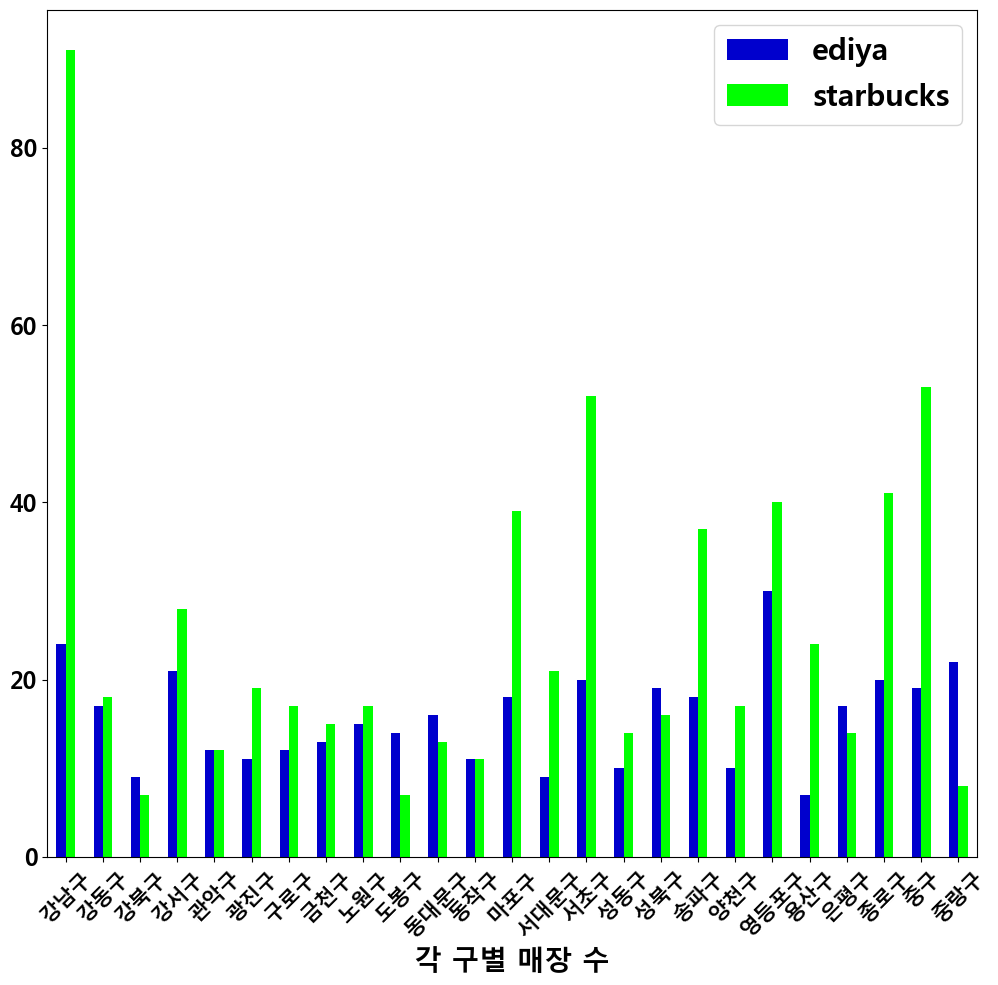

In [50]:
df_sumCount.plot.bar(fontsize=15, rot=0, figsize=(12,11), color=["mediumblue", "lime"])
plt.xticks(rotation=45)
plt.xlabel("각 구별 매장 수", fontdict={"size":20})
plt.yticks(fontsize=17)
plt.legend(fontsize=22)
print("")

각 구의 이디야와 스타벅스의 매장 수의 합

In [51]:
df_shop_count = pd.DataFrame(df_sumCount.sum(axis=1), index=gu_list, columns=["sum"]).sort_values('sum', ascending=False)
df_shop_count

,sum
강남구,115
중구,72
서초구,72
영등포구,70
종로구,61
마포구,57
송파구,55
강서구,49
강동구,35
성북구,35


<h3>각 구마다 스타벅스 대비 이디야 매장의 비율</h3>

이디야 매장비율 가장 높은 구들
      ediya_ratio
중랑구          73.3
도봉구          66.7
강북구          56.2
동대문구         55.2
은평구          54.8


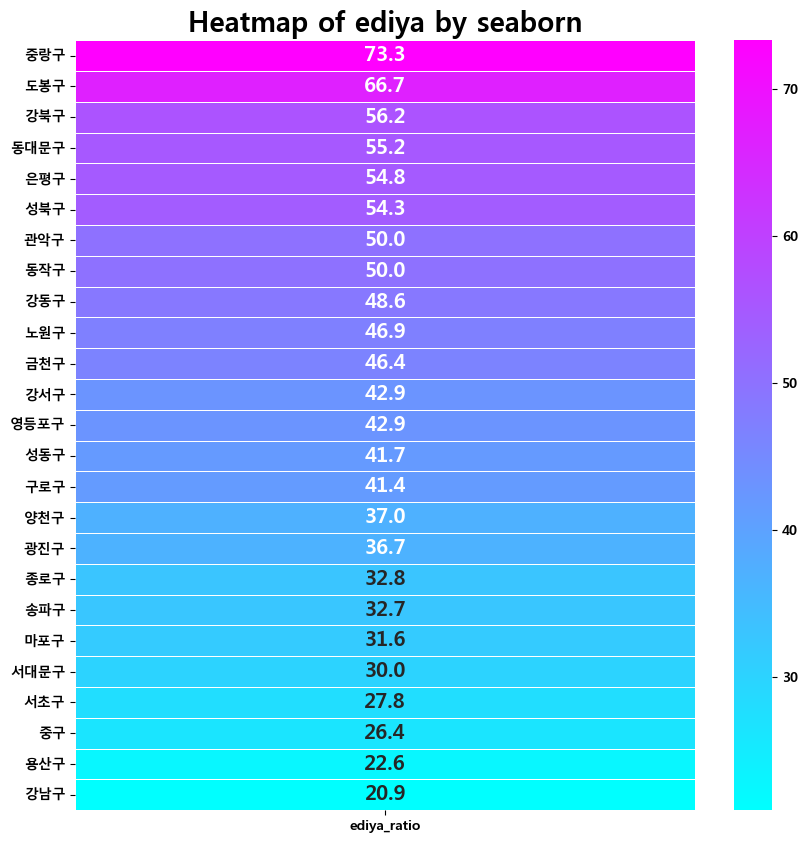

In [52]:
# 각 구의 스타벅스 대비 이디야 매장 비율
df_ratio_e = df_sumCount['ediya'] / df_shop_count["sum"]
round(df_ratio_e * 100, 1)
df_ratio_e = pd.DataFrame(round(df_ratio_e * 100, 1), index=gu_list, columns=["ediya_ratio"])
df_ratio_e = df_ratio_e.sort_values('ediya_ratio',ascending=False)
print("이디야 매장비율 가장 높은 구들")
print(df_ratio_e.head())
plt.figure(figsize=(10,10))
sns.heatmap(df_ratio_e, cmap='cool', annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5)
plt.title('Heatmap of ediya by seaborn', fontsize=20)
plt.show()

<h5>스타벅스가 제일 많은 지역 TOP5</h5>

In [53]:
df_sumCount["starbucks"].sort_values(ascending=False).head()

gu
강남구     91
중구      53
서초구     52
종로구     41
영등포구    40
Name: starbucks, dtype: int64

스타벅스 매장비율 가장 높은 구들
      starbucks_ratio
강남구              79.1
용산구              77.4
중구               73.6
서초구              72.2
서대문구             70.0


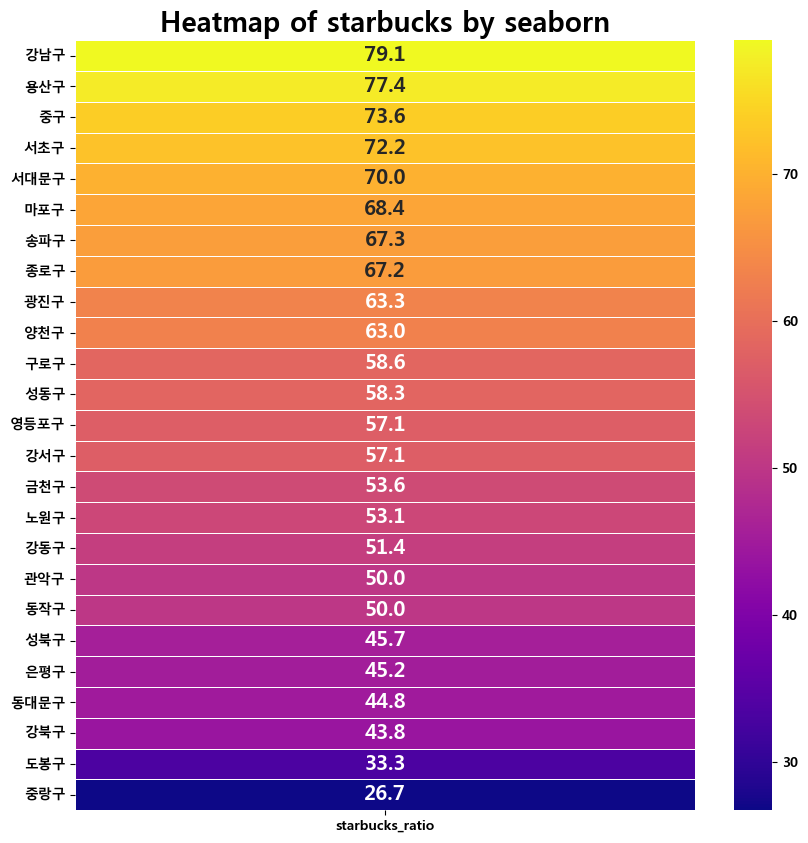

In [54]:
df_ratio_s = df_sumCount['starbucks'] / df_shop_count["sum"]
round(df_ratio_s * 100, 1)
df_ratio_s = pd.DataFrame(round(df_ratio_s * 100, 1), index=gu_list, columns=["starbucks_ratio"])
df_ratio_s = df_ratio_s.sort_values('starbucks_ratio',ascending=False)
print("스타벅스 매장비율 가장 높은 구들")
print(df_ratio_s.head())
plt.figure(figsize=(10,10))
sns.heatmap(df_ratio_s, annot=True, annot_kws={"size": 15}, fmt='.1f', linewidths=.5, cmap='plasma')
plt.title('Heatmap of starbucks by seaborn', fontsize=20)
plt.show()

<h3>두 브랜드의 상관관계를 살펴보면</h3>

두 브랜드의 상관관계를 확인하기 위해 두 브랜드의 각 구마다의 숫자와 비율의 데이터 프레임을 합쳤다.

In [56]:
df_merge = pd.merge(df_ratio_e,df_ratio_s, on=df_sumCount.index)
del df_merge["key_0"]
df_merge = pd.merge(df_sumCount, df_merge, on=df_sumCount.index)
df_merge.iloc[-1] = ['총계', df_merge['ediya'].sum(), df_merge['starbucks'].sum(), df_merge['ediya_ratio'].sum(), df_merge['starbucks_ratio'].sum()]
# del df_merge["key_0"]
df_merge.set_index("key_0", inplace=True)

df_corr = df_merge.corr()
df_merge

,ediya,starbucks,ediya_ratio,starbucks_ratio
key_0,,,,
강남구,24,91,73.3,79.1
강동구,17,18,66.7,77.4
강북구,9,7,56.2,73.6
강서구,21,28,55.2,72.2
관악구,12,12,54.8,70.0
광진구,11,19,54.3,68.4
구로구,12,17,50.0,67.3
금천구,13,15,50.0,67.2
노원구,15,17,48.6,63.3


In [57]:
df_corr

,ediya,starbucks,ediya_ratio,starbucks_ratio
ediya,1.000000,0.992602,0.995557,0.996221
starbucks,0.992602,1.000000,0.986783,0.986527
ediya_ratio,0.995557,0.986783,1.000000,0.999773
starbucks_ratio,0.996221,0.986527,0.999773,1.000000


<Axes: >

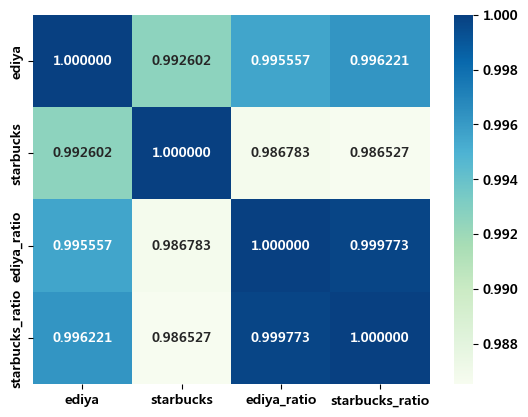

In [58]:
sns.heatmap(df_corr, cmap="GnBu", annot=True, fmt=".6f")

<Figure size 1000x1000 with 0 Axes>

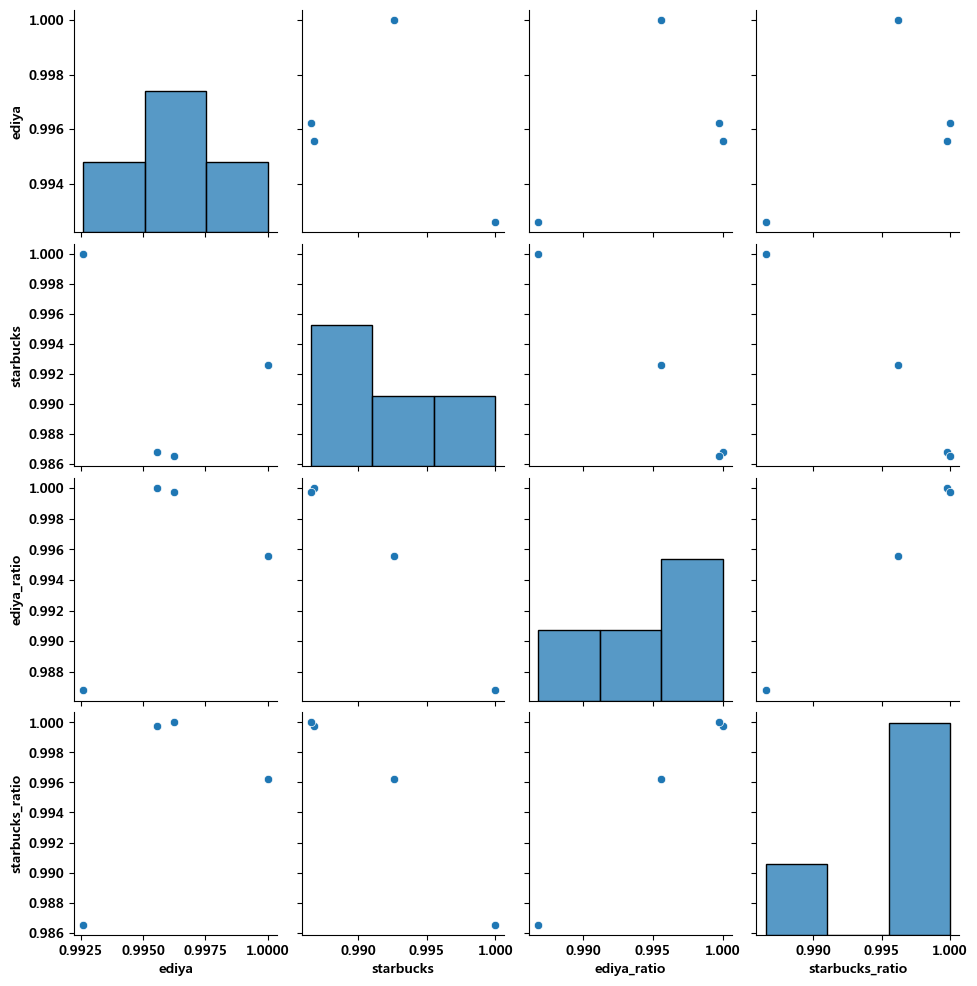

<Figure size 1000x1000 with 0 Axes>

In [63]:
sns.pairplot(df_corr)
plt.figure(figsize=(10,10))

<h5>위 의 상관계수를 보면 두 브랜드와 매장 장소의 관계는 크게 없는 것으로 보인다.</h5>

<h2>위 데이터들을 지도로 시각화</h2>

In [53]:
import folium
import json
mapping = folium.Map(location=[37.5502, 126.982], zoom_start=10.5, titles="OpenStreetMap")

geo_path = "./skorea_municipalities_geo_simple.json"
geo_str = json.load(open(geo_path, encoding="utf-8"))

setting = folium.Choropleth(geo_data=geo_str,
                            data=df_ratio,
                            columns=[df_ratio.index, "ediya_ratio"],
                            key_on="properties.name",
                            fill_color="YlOrRd")

setting.add_to(mapping)

<h3>색이 진한 구역일수록 스타벅스보다 이디야의 비율가 높음<h3>

In [54]:
for idx, rows in df_concat.iterrows():
    if rows["brand"] == "ediya":
        mk_color = "blue"
    elif rows["brand"] == "starbucks":
        mk_color = "red"

    if pd.notnull(rows['lat']) and pd.notnull(rows["lng"]):
        folium.Marker(
            location= [rows['lat'], rows['lng']],
            popup = rows['addr'],
            tooltip=rows['name'],
            icon=folium.Icon(
                icon="coffee",
                prefix="fa",
                color = mk_color
            )
        ).add_to(mapping)

mapping

<h5>결론 : 이디야와 스타벅스 커피매장을 확인해봤을 때 스타벅스가 가장 많은 강남구, 중구, 서초구보다 다른 구에서 더 많은 수의 이디야의 커피매장 비율의 수가 더 높은 것을 확인할 수 있다. 따라서 이디야가 스타벅스를 전략적으로 같은 곳에 매장을 설치한 것으로 보기 어렵다. 서울시에 스탁벅스의 숫자가 많으며 커피매장은 직장인들이 많이 모이는 곳에 같이 모이다 보니 이러한 의심을 받은 것 같다.</h5>

<h5>추가로 개인적인 생각으로는 스타벅스의 매장 주변을 따라다니는 것은 좋은 전략이라 생각한다. 스타벅스의 경우 장기간 이용 손님과 많은 이용자로 인해 포장 구매자나 매장 구매자 둘 다 오래 기다리거나 이용하지 못 하게 되는 상황이 발생한다. 이러한 틈새를 이용하는 것도 또한 전략이라 생각한다.</h5>